In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from pydicom import dcmread
import warnings
from sklearn.preprocessing import LabelEncoder
import pickle
import gc
import ctypes
from sklearn.model_selection import train_test_split
import tensorflow as tf
#from tensorflow import keras
from tensorflow.python.keras import backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

2024-08-14 05:09:51.101613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 05:09:51.101708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 05:09:51.236624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [3]:
config = {}

config['feature_file_path'] \
= '/kaggle/input/left-neural-foraminal-narrowing-training/left_neural_foraminal_narrowing_l2_l3_training_features'
config['labels_file_path'] \
= '/kaggle/input/left-neural-foraminal-narrowing-training/left_neural_foraminal_narrowing_l2_l3_feature_metadata_labels'

In [4]:
with open(config['feature_file_path'], "rb") as file:
    extracted_training_features = pickle.load(file)
    
with open(config['labels_file_path'], "rb") as file:
    labels = pickle.load(file)

In [5]:
extracted_training_features_resized = []

for img in extracted_training_features:
    extracted_training_features_resized.append(np.resize(img,(128,)))
    
final = np.array(extracted_training_features_resized)
labels_vstacked = np.vstack(labels)

print(final.shape)
print(labels_vstacked.shape)

(147083, 128)
(147083, 1)


In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[128]))
model.add(tf.keras.layers.Dense(210, activation="relu"))
model.add(tf.keras.layers.Dense(170, activation="relu"))
model.add(tf.keras.layers.Dense(65, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(final, labels_vstacked, test_size=0.3, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)

(102958, 128)
(102958, 1)
(35300, 128)
(35300, 1)
(8825, 128)
(8825, 1)


In [8]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=110, validation_data=(x_valid, y_valid))

Epoch 1/110
 103/3218 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8143 - loss: 8.3213     

I0000 00:00:1723612264.295579     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3218/3218 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8687 - loss: 1.6215 - val_accuracy: 0.9070 - val_loss: 0.3303
Epoch 2/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9028 - loss: 0.3432 - val_accuracy: 0.9070 - val_loss: 0.3294
Epoch 3/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9015 - loss: 0.3507 - val_accuracy: 0.9071 - val_loss: 0.3289
Epoch 4/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8990 - loss: 0.3506 - val_accuracy: 0.9071 - val_loss: 0.3349
Epoch 5/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9016 - loss: 0.3466 - val_accuracy: 0.9071 - val_loss: 0.3294
Epoch 6/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9017 - loss: 0.3448 - val_accuracy: 0.9071 - val_loss: 0.3288
Epoch 7/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9023 - loss: 0.3436 - val_accuracy: 0.9071 - val_loss: 0.3284
Epoch 8/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9009 - loss: 0.3479 - val

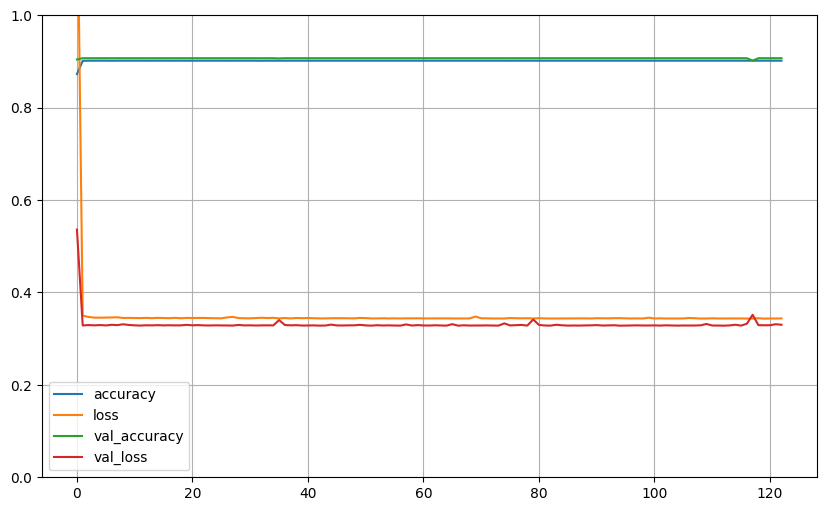

In [11]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [15]:
model.evaluate(x_test, y_test)

1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9629 - loss: 0.1631


[0.16080813109874725, 0.9633994102478027]

In [16]:
model.save("keras_base_left_neural_foraminal_narrowing_l1_l2.h5")